# [IAPR 2018:][iapr2018] Lab 2 ‒  Object description

**Author:** Axel Manguy
**Due date:** 04.05.2018
**Group:** Quentin Desaulty, Axel Manguy

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization and contour spectrum

Before doing any operation on images, and since we're going to extract frequencies, one first idea is to look at the spectrum of each contour. Using the marching square algorithm through the find_contour method from skimage (details in section 1.2.2), the amplitude are plotted for the 10 first frequencies. It appears that the first frequency performs well at distinguishing 0 from 1. All other frequencies are not relevant features for that task.

Text(0.5,1,'2nd descriptor (module)')

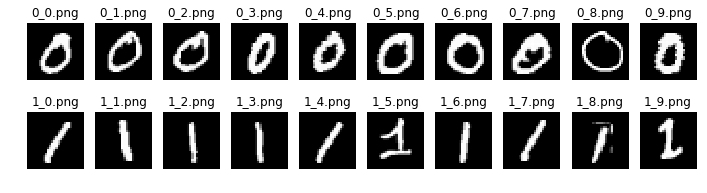

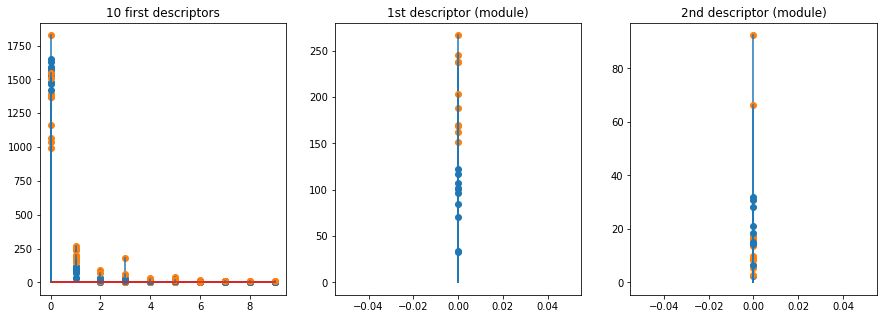

In [2]:
import skimage.io
from skimage import measure
from skimage import feature
from skimage import filters
from skimage import morphology
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from scipy.fftpack import fft, ifft
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
fft_lst_1,fft_lst_0=[],[]
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 1)
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])#contours definition using marching squares
    fourier=fft(signal)
    fft_lst_0.append(fourier)
    ax.imshow(im,cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
#loop on ones
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 1)
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])#contours definition using marching squares
    fourier=fft(signal)
    fft_lst_1.append(fourier)
    ax.imshow(im,cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
fig2, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
for i,fourier in enumerate(fft_lst_0):
    ax1.stem(abs(fft_lst_0[i][0:10]),label='0')
    ax1.stem(abs(fft_lst_1[i][0:10]),label='1',markerfmt='C1o')
    ax2.stem(abs(fft_lst_0[i][1:2]),label='0')
    ax2.stem(abs(fft_lst_1[i][1:2]),label='1',markerfmt='C1o')
    ax3.stem(abs(fft_lst_0[i][2:3]),label='0')
    ax3.stem(abs(fft_lst_1[i][2:3]),label='1',markerfmt='C1o')
ax1.set_title('10 first descriptors')
ax2.set_title('1st descriptor (module)')
ax3.set_title('2nd descriptor (module)')

### 1.2 Fourier descriptors
Two different methods are tested for finding a contour. Since we're doing Fourier descriptors, a contour that progresses along the shape with a starting point and an end point is needed. Then, that contour can be converted into a relevant signal. The two methods we found to achieve that task are active_contour (a minimizing energy method) and find_contour (a marching square method). 

#### 1.2.2 Fourier descriptors : active_contour

One main drawback of the active_contour method is the difficulty to find the good set of parameters that will achieve the task. In order to help the function to give the right contour, we skeletonize the initial shape with a Gaussian filter so the center of shapes appears bright and the edges more blurred. This way, the snake will be attracted by the center of the shape rather than the details of its border. This is especially useful for 1_5 and 1_9 that have an odd shape. For these images, the method performs well and is able to extract some abstract shape of a one (just a straight line with a thickness and an orientation). However, the method is still making mistakes on 1_8, taking a noise as a part of the shape. Since there are very few pixels, the morphology operations we tried was destroying too much of the shapes to be able to retrieve contours, so we decide to not implement them.

By performing a Fourier transform on images, we can extract f1 and f2. Without the phase and f0, the descriptors we selected are invariant to translation and rotation. The rotation invariant is relevant since the one shapes can be inclined. Since all image has the same size and all shape more or less the same scale being scaling invariant is not that much important. However, and as expected the use of f1 is enough to discriminate between one and zeros.


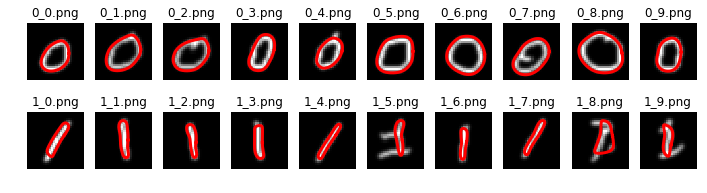

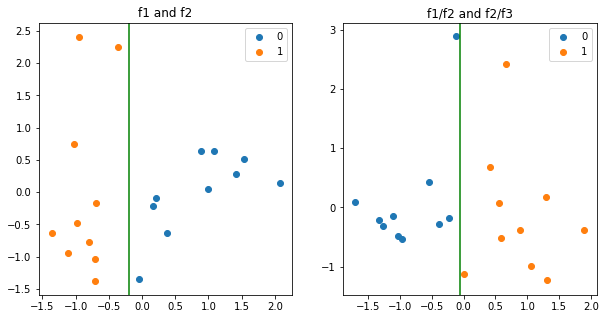

f1 and f2 :intra-class variance for zeros: 0.43 and  0.35
f1 and f2 :intra-class variance for ones : 0.07 and  1.65
ratios :intra-class variance for zeros: 0.25 and  0.92
ratios :intra-class variance for ones : 0.26 and  1.05


In [3]:
from skimage import feature
from skimage import filters
from skimage import morphology
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from scipy.fftpack import fft, ifft
from skimage.morphology import skeletonize
import numpy as np

#plot and list definition
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
feature_list_0=[]
feature_list_1=[]
feature_list_0_ratio=[]
feature_list_1_ratio=[]

#snake initialisation
s = np.linspace(0, 2*np.pi, 400)
x = 13.5 + 12*np.cos(s)
y = 13 + 12*np.sin(s)
init = np.array([x, y]).T

#loop on zeros
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #active contour on filtered skeleton
    zeros=im>0.9
    skeleton = skeletonize(zeros)
    snake_sk = active_contour(gaussian(skeleton),init, alpha=0.2, beta=8e3, gamma=0.1, w_line=-0.2)
    
    #signal creation
    signal = snake_sk[:, 0]+(1j*snake_sk[:, 1])
    
    #fourier transform
    fourier=fft(signal)
    
    #2 first coef extraction
    #abs to get to module invariant to rotation
    #not taking f0 to be invariant to translation
    feature_list_0.append([np.abs(fourier[1]),np.abs(fourier[2])])
    feature_list_0_ratio.append([np.abs(fourier[0])/np.abs(fourier[1]),np.abs(fourier[1])/np.abs(fourier[2])])
    
    #plotting
    ax.imshow(gaussian(skeleton), cmap=plt.cm.gray)
    ax.plot(snake_sk[:, 0], snake_sk[:, 1], '-r', lw=3)
    ax.axis('off')
    ax.set_title(nm)
    
#loop on ones
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #active contour
    zeros=im>0.9
    skeleton = skeletonize(zeros)
    #active contour parameters are the same for ones and zeros, so a future automated system
    #could perform detection not knowing if it's one or zero.
    snake_sk = active_contour(gaussian(skeleton),init, alpha=0.2, beta=8e3, gamma=0.1, w_line=-0.2)
    
    #signal creation
    signal = snake_sk[:, 0]+(1j*snake_sk[:, 1])
    
    #fourier transform
    fourier=fft(signal)
    
    #2 first coef extraction
    feature_list_1.append([np.abs(fourier[1]),np.abs(fourier[2])])
    feature_list_1_ratio.append([np.abs(fourier[0])/np.abs(fourier[1]),np.abs(fourier[1])/np.abs(fourier[2])])
    
    #plotting
    ax.plot(snake_sk[:, 0], snake_sk[:, 1], '-r', lw=3)
    ax.imshow(gaussian(skeleton), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
#first plot without phase
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
#normalization for statistics
f1=np.concatenate((feature_list_0.T[0],feature_list_1.T[0]))
f2=np.concatenate((feature_list_0.T[1],feature_list_1.T[1]))
feature_list_0.T[0]=(feature_list_0.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1.T[0]=(feature_list_1.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0.T[1]=(feature_list_0.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1.T[1]=(feature_list_1.T[1]-np.mean(f2))/(np.std(f2))
ax1.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
ax1.axvline(x=-0.2, color='g')
ax1.set_title('f1 and f2')
ax1.legend()

#second plot on ratio
feature_list_0_ratio,feature_list_1_ratio=np.array(feature_list_0_ratio),np.array(feature_list_1_ratio)
f1_ratio=np.concatenate((feature_list_0_ratio.T[0],feature_list_1_ratio.T[0]))
f2_ratio=np.concatenate((feature_list_0_ratio.T[1],feature_list_1_ratio.T[1]))
feature_list_0_ratio.T[0]=(feature_list_0_ratio.T[0]-np.mean(f1_ratio))/(np.std(f1_ratio))
feature_list_1_ratio.T[0]=(feature_list_1_ratio.T[0]-np.mean(f1_ratio))/(np.std(f1_ratio))
feature_list_0_ratio.T[1]=(feature_list_0_ratio.T[1]-np.mean(f2_ratio))/(np.std(f2_ratio))
feature_list_1_ratio.T[1]=(feature_list_1_ratio.T[1]-np.mean(f2_ratio))/(np.std(f2_ratio))
ax2.scatter(feature_list_0_ratio.T[0], feature_list_0_ratio.T[1],label='0')
ax2.scatter(feature_list_1_ratio.T[0], feature_list_1_ratio.T[1],label='1')
ax2.legend()
ax2.set_title('f1/f2 and f2/f3')
ax2.axvline(x=-0.05, color='g')
plt.show()

#displaying intra and extra class variance
print('f1 and f2 :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1])))
print('f1 and f2 :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1])))
print('ratios :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0_ratio.T[0]),np.var(feature_list_0_ratio.T[1])))
print('ratios :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1_ratio.T[0]),np.var(feature_list_1_ratio.T[1])))

#### 1.2.2 Fourier descriptors : find_contour
Even if the previous method was performing well on finding contour, we also wanted to try a method that takes the whole shape into account. Especially for the 1, only taking the straight line in the center deletes some information that could be useful for other recognition. The find contour method works by dividing the area into a grid and performing a linear interpolation. For each cell of the grid, the marching square method looks at the grayscale value of each corner to define the isoline. In our case, the isoline will be the contour we're searching for.

The method for feature extraction is the same as before, we first construct the signal based on the contour. Then a Fourier transform is applied to that signal and finally  f1 and f2 are taken as descriptors. The results are the same as before except the intraclass variance is a little bit better for zeros. Since we are taking the whole shape of the ones, the intra-class variance for the ones is higher due to 1_5 and 1-9.

In order to compare the two methods, a normalization on data is performed so the variance computation is done on the same scale.

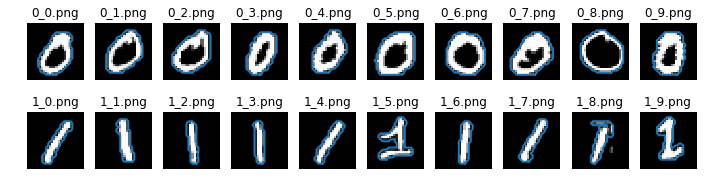

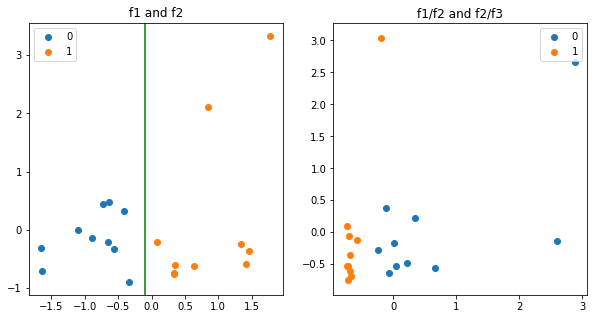

f1 and f2 :intra-class variance for zeros: 0.20 and  0.19
f1 and f2 :intra-class variance for ones : 0.32 and  1.77
ratios    :intra-class variance for zeros: 1.16 and  0.86
ratios    :intra-class variance for ones : 0.02 and  1.13


In [4]:
from skimage import measure
#plot and list definition
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
feature_list_0=[]
feature_list_1=[]
feature_list_0_ratio=[]
feature_list_1_ratio=[]

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 1)
    
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    
    #fourier transform
    fourier=fft(signal)
    
    #2 first coef extraction
    feature_list_0.append([np.abs(fourier[1]),np.abs(fourier[2])])
    feature_list_0_ratio.append([np.abs(fourier[0])/np.abs(fourier[1]),np.abs(fourier[5])/np.abs(fourier[6])])
    
    #plotting
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)
    
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    
    #fourier transform
    fourier=fft(signal)
    
    #2 first coef extraction
    feature_list_1.append([np.abs(fourier[1]),np.abs(fourier[2])])
    feature_list_1_ratio.append([np.abs(fourier[0])/np.abs(fourier[1]),np.abs(fourier[3])/np.abs(fourier[4])])
    
    #plotting
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
#first plot without phase
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
#normalization for statistics
f1=np.concatenate((feature_list_0.T[0],feature_list_1.T[0]))
f2=np.concatenate((feature_list_0.T[1],feature_list_1.T[1]))
feature_list_0.T[0]=(feature_list_0.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1.T[0]=(feature_list_1.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0.T[1]=(feature_list_0.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1.T[1]=(feature_list_1.T[1]-np.mean(f2))/(np.std(f2))
ax1.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
ax1.axvline(x=-0.1, color='g')
ax1.legend()
ax1.set_title('f1 and f2')

#second plot on ratio
feature_list_0_ratio,feature_list_1_ratio=np.array(feature_list_0_ratio),np.array(feature_list_1_ratio)
f1_ratio=np.concatenate((feature_list_0_ratio.T[0],feature_list_1_ratio.T[0]))
f2_ratio=np.concatenate((feature_list_0_ratio.T[1],feature_list_1_ratio.T[1]))
feature_list_0_ratio.T[0]=(feature_list_0_ratio.T[0]-np.mean(f1_ratio))/(np.std(f1_ratio))
feature_list_1_ratio.T[0]=(feature_list_1_ratio.T[0]-np.mean(f1_ratio))/(np.std(f1_ratio))
feature_list_0_ratio.T[1]=(feature_list_0_ratio.T[1]-np.mean(f2_ratio))/(np.std(f2_ratio))
feature_list_1_ratio.T[1]=(feature_list_1_ratio.T[1]-np.mean(f2_ratio))/(np.std(f2_ratio))
ax2.scatter(feature_list_0_ratio.T[0], feature_list_0_ratio.T[1],label='0')
ax2.scatter(feature_list_1_ratio.T[0], feature_list_1_ratio.T[1],label='1')
ax2.set_title('f1/f2 and f2/f3')
ax2.legend()
plt.show()

#displaying intra and extra class variance
print('f1 and f2 :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1])))
print('f1 and f2 :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1])))
print('ratios    :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0_ratio.T[0]),np.var(feature_list_0_ratio.T[1])))
print('ratios    :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1_ratio.T[0]),np.var(feature_list_1_ratio.T[1])))

### 1.4 Region Based Descriptors

For region-based descriptors, 3 different couples of descriptors have been tried. The region is extracted through the same method we used in the previous lab. Each detected region have all the most useful descriptors. When there is more than one region, the region of maximum area is taken as the most relevant one.

The first couple is performing well and both area and perimeter are features that can be used on their own to perform the detection (with a simple threshold). Thus these two descriptors will be good for detection. The eigenvalues give disappointing results and do not seems to be good enough for our task. The compacity and rectangularity gives also good results even if the compacity is less efficient than rectangularity.

Finally, the intra-class variance for area and perimeter are both excellent. These two descriptors seems to be the best so far.

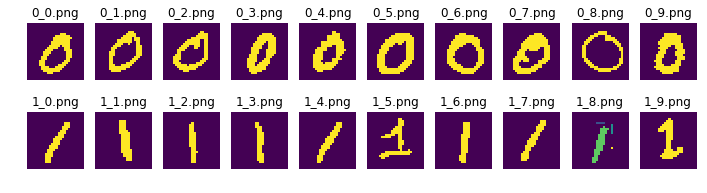

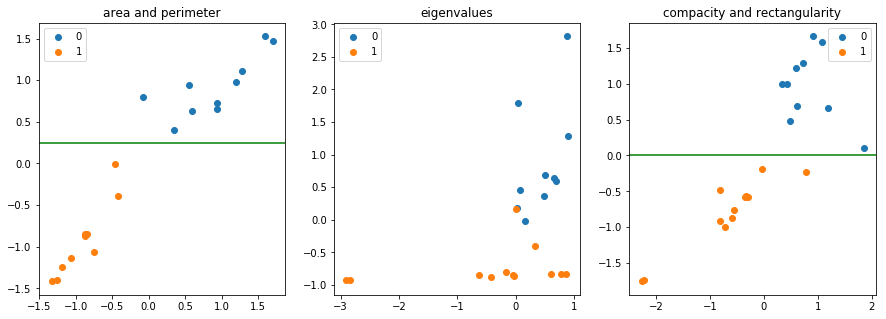

A and P :intra-class variance for zeros: 0.28 and  0.12
A and P :intra-class variance for ones : 0.09 and  0.18
C and R :intra-class variance for zeros: 0.19 and  0.22
C and R :intra-class variance for ones : 0.66 and  0.23


In [5]:
from skimage import measure
from skimage.morphology import binary_opening,erosion,closing,square
from skimage.morphology import skeletonize
from matplotlib.lines import Line2D 

#feature list initialization
feature_list_0=[]
feature_list_1=[]
feature_list_0_ev=[]
feature_list_1_ev=[]
feature_list_0_cr=[]
feature_list_1_cr=[]

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    feature_list_0.append([0,0])
    
    for props in regions:
        #adding area and perimeter as feature
        feature_list_0[-1][0]=max(feature_list_0[-1][0],props.area)
        feature_list_0[-1][1]=max(feature_list_0[-1][1],props.perimeter)
        
        #selecting the largest area (for 1_8)
        if props.area == max(feature_list_0[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_0_ev.append([eigvals[0],eigvals[1]])
            
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_0_cr.append([compacity ,rectangularity])
    
    #plotting
    ax.imshow(label_img)
    ax.axis('off')
    ax.set_title(nm)
    
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #regions detections
    label_img = measure.label(im>100)
    regions = measure.regionprops(label_img)
    feature_list_1.append([0,0])
    
    for props in regions:
        #adding area and perimeter as feature
        feature_list_1[-1][0]=max(feature_list_1[-1][0],props.area)
        feature_list_1[-1][1]=max(feature_list_1[-1][1],props.perimeter)
        
        if props.area == max(feature_list_1[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_1_ev.append([eigvals[0],eigvals[1]])
            
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_1_cr.append([compacity ,rectangularity])
            
    #plotting    
    ax.imshow(label_img)
    ax.axis('off')
    ax.set_title(nm)
    

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
#first plot and normalization to compare
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
f1=np.concatenate((feature_list_0.T[0],feature_list_1.T[0]))
f2=np.concatenate((feature_list_0.T[1],feature_list_1.T[1]))
feature_list_0.T[0]=(feature_list_0.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1.T[0]=(feature_list_1.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0.T[1]=(feature_list_0.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1.T[1]=(feature_list_1.T[1]-np.mean(f2))/(np.std(f2))
ax1.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
ax1.axhline(y=0.25, color='g')
ax1.set_title('area and perimeter')
ax1.legend()

#second plot and also normalization
feature_list_0_ev,feature_list_1_ev=np.array(feature_list_0_ev),np.array(feature_list_1_ev)
f1=np.concatenate((feature_list_0_ev.T[0],feature_list_1_ev.T[0]))
f2=np.concatenate((feature_list_0_ev.T[1],feature_list_1_ev.T[1]))
feature_list_0_ev.T[0]=(feature_list_0_ev.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1_ev.T[0]=(feature_list_1_ev.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0_ev.T[1]=(feature_list_0_ev.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1_ev.T[1]=(feature_list_1_ev.T[1]-np.mean(f2))/(np.std(f2))
ax2.scatter(feature_list_0_ev.T[0], feature_list_0_ev.T[1],label='0')
ax2.scatter(feature_list_1_ev.T[0], feature_list_1_ev.T[1],label='1')
ax2.set_title('eigenvalues')
ax2.legend()

#third plot and also normalization
feature_list_0_cr,feature_list_1_cr=np.array(feature_list_0_cr),np.array(feature_list_1_cr)
f1=np.concatenate((feature_list_0_cr.T[0],feature_list_1_cr.T[0]))
f2=np.concatenate((feature_list_0_cr.T[1],feature_list_1_cr.T[1]))
feature_list_0_cr.T[0]=(feature_list_0_cr.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1_cr.T[0]=(feature_list_1_cr.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0_cr.T[1]=(feature_list_0_cr.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1_cr.T[1]=(feature_list_1_cr.T[1]-np.mean(f2))/(np.std(f2))
ax3.scatter(feature_list_0_cr.T[0], feature_list_0_cr.T[1],label='0')
ax3.scatter(feature_list_1_cr.T[0], feature_list_1_cr.T[1],label='1')
ax3.axhline(y=0, color='g')
ax3.set_title('compacity and rectangularity')
ax3.legend()
plt.show()

#displaying intra and extra class variance
print('A and P :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1])))
print('A and P :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1])))
print('C and R :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0_cr.T[0]),np.var(feature_list_0_cr.T[1])))
print('C and R :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1_cr.T[0]),np.var(feature_list_1_cr.T[1])))

### 1.5 Distance Based Descriptors

Also based on contour, this method encodes first the contour as a string were order matter. The Wagner-Ficher algorithm to compute the edit-distance is taken from the Wikipedia pseudo-code description. Since no distance have been used, the computation is quite slow. 

However, a distance is not a descriptor, and the feature is usually the distance to a reference shape. Since the measures are only made on zeros and ones, the reference shapes will be a circle for the zeros and a rectangle for the ones. Requiring a reference shape is still a major drawback of that method and thus cannot be used for classifying 3 and 2, unless a general reference shape is available for these two digits.

In terms of results, the method performs well especially for distance to the circle that seems to be enough to discriminate zeros from ones.

4.0
3.0


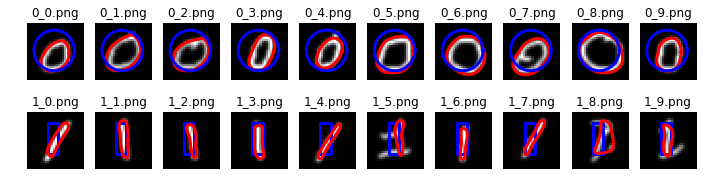

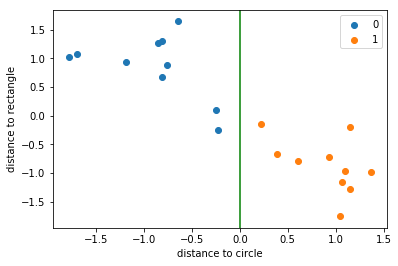

f1 and f2 :intra-class variance for zeros: 0.25 and  0.29
f1 and f2 :intra-class variance for ones : 0.12 and  0.21


In [6]:
from skimage.draw import polygon_perimeter

def contour2path(contour):
    path=[]
    #0.15 corresponds to the usual step between to positions
    directions = 0.15*np.array([[1, 0],[1,-1],[0,-1],[-1,-1],[-1, 0],[-1, 1],[0, 1],[1, 1]])
    for i,pos in enumerate(contour):
        if i == len(contour)-1:
            return path
        newpos = pos + directions
        dist = np.sum(np.abs(np.array(contour[i+1])-newpos),1)
        path.append(str(np.argmin(dist)))
        

#                      From wikipedia
#https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
#
def edit_distance(path1,path2):
    #For all i and j, d[i,j] will hold the Levenshtein distance between
    # the first i characters of s and the first j characters of t.
    # Note that d has (m+1) x (n+1) values.
    #let d be a 2-d array of int with dimensions [0..m, 0..n]
    d=np.zeros((len(path1)+1,len(path2)+1))
    for i in range(len(path1)+1):
        d[i, 0] = i 
        # the distance of any first string to an empty second string
        # (transforming the string of the first i characters of s into
        # the empty string requires i deletions)
    for j in range(len(path2)+1):
        d[0, j] = j # the distance of any second string to an empty first string
  
    for j in range(1,len(path2)+1):
        for i in range(1,len(path1)+1):
            #print(i,j)
            if path1[i-1] == path2[j-1] :
                d[i, j] = d[i-1, j-1] # no operation required
            else:
                d[i, j] = np.min([d[i-1, j] + 1,
                                  d[i, j-1] + 1,
                                  d[i-1, j-1] + 1])
    return d[len(path1),len(path2)]
print(edit_distance('saturda','sunday'))
print(edit_distance('12345','125489'))

#snake initialisation
s = np.linspace(0, 2*np.pi, 400)
x = 13.5 + 12*np.cos(s)
y = 13 + 12*np.sin(s)
init = np.array([x, y]).T

#reference circle
s = np.linspace(0, 2*np.pi, 400)
x = 13 + 10*np.cos(s)
y = 13 + 10*np.sin(s)
ref_circle = np.array([x, y]).T
#print(''.join(contour2path(ref_circle)))

#reference rectangle
x = np.concatenate((np.linspace(10,10,134),np.linspace(10,15,66),np.linspace(15,15,134),np.linspace(15,10,66)))
y = np.concatenate((np.linspace(5,20,134),np.linspace(20,20,66),np.linspace(20,5,134),np.linspace(5,5,66)))
fig, axes = plt.subplots(2, len(ones_im), figsize=(12, 3))
ref_rect = np.array([x, y]).T
#print(''.join(contour2path(ref_rect)))

chainref_circle = ''.join(contour2path(ref_circle[:-1]))
chainref_rect = ''.join(contour2path(ref_rect[:-1]))
    
feature_list_0=[]
feature_list_1=[]
    
for ax,im, nm in zip(axes[0],zeros_im, zeros_names):
    zeros=im>0.9
    skeleton = skeletonize(zeros)
    snake_sk = active_contour(gaussian(skeleton),init, alpha=0.2, beta=8e3, gamma=0.1, w_line=-0.2)
    #chain code
    chain = ''.join(contour2path(snake_sk))
    feature_list_0.append([edit_distance(chain,chainref_circle),
                           edit_distance(chain,chainref_rect)])
    ax.plot(snake_sk[:, 0], snake_sk[:, 1], '-r', lw=3)
    ax.plot(ref_circle[:, 0], ref_circle[:, 1], 'b', lw=3)
    ax.imshow(gaussian(skeleton), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax,im, nm in zip(axes[1],ones_im, ones_names):
    zeros=im>0.9
    skeleton = skeletonize(zeros)
    snake_sk = active_contour(gaussian(skeleton),init, alpha=0.2, beta=8e3, gamma=0.1, w_line=-0.2)
    #chain code
    chain = ''.join(contour2path(snake_sk))
    feature_list_1.append([edit_distance(chain,chainref_circle),
                           edit_distance(chain,chainref_rect)])
    ax.plot(x, y, 'b', lw=3)
    ax.plot(snake_sk[:, 0], snake_sk[:, 1], '-r', lw=3)
    ax.imshow(gaussian(skeleton), cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

plt.figure()
#first plot without phase
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
#normalization for statistics
f1=np.concatenate((feature_list_0.T[0],feature_list_1.T[0]))
f2=np.concatenate((feature_list_0.T[1],feature_list_1.T[1]))
feature_list_0.T[0]=(feature_list_0.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1.T[0]=(feature_list_1.T[0]-np.mean(f1))/(np.std(f1))
feature_list_0.T[1]=(feature_list_0.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1.T[1]=(feature_list_1.T[1]-np.mean(f2))/(np.std(f2))
plt.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
plt.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
plt.axvline(x=0, color='g')
plt.xlabel('distance to circle')
plt.ylabel('distance to rectangle')
plt.legend()
plt.show()

print('f1 and f2 :intra-class variance for zeros: {:.02f} and  {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1])))
print('f1 and f2 :intra-class variance for ones : {:.02f} and  {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1]))) 

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 1.1 Data visualization

For the same reasons as before, the contours frequencies are first plotted to see what are the best frequencies for the task. Unfortunately, there is here no frequency that is good enough to discriminate all 4 pictures. Since f1 was a good feature it is kept to at least discriminate zeros from ones. Then another frequency that does the job for 3 and 2 is searched. Here f5 seems to be the better even if not perfect.

The conclusion of these tests is that it's impossible to discriminate all 4 digits with only 2 features

Text(0.5,1,'descriptor no5 (module)')

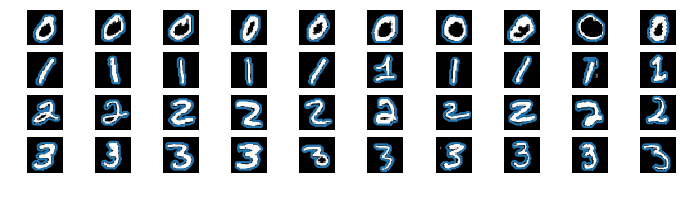

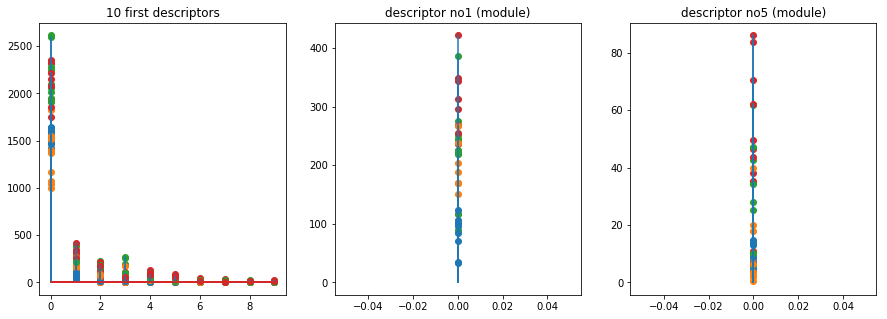

In [7]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

fft_lst_1,fft_lst_0=[],[]
fft_lst_2,fft_lst_3=[],[]
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    fourier=fft(signal)
    fft_lst_0.append(fourier)
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    fourier=fft(signal)
    fft_lst_1.append(fourier)
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    fourier=fft(signal)
    fft_lst_2.append(fourier)
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])
    fourier=fft(signal)
    fft_lst_3.append(fourier)
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')

fig2, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
for i,fourier in enumerate(fft_lst_0):
    ax1.stem(abs(fft_lst_0[i][0:10]),label='0')
    ax1.stem(abs(fft_lst_1[i][0:10]),label='1',markerfmt='C1o')
    ax1.stem(abs(fft_lst_2[i][0:10]),label='2',markerfmt='C2o')
    ax1.stem(abs(fft_lst_3[i][0:10]),label='3',markerfmt='C3o')
    
    ax2.stem(abs(fft_lst_0[i][1:2]),label='0')
    ax2.stem(abs(fft_lst_1[i][1:2]),label='1',markerfmt='C1o')
    ax2.stem(abs(fft_lst_2[i][1:2]),label='2',markerfmt='C2o')
    ax2.stem(abs(fft_lst_3[i][1:2]),label='3',markerfmt='C3o')
    
    ax3.stem(abs(fft_lst_0[i][5:6]),label='0')
    ax3.stem(abs(fft_lst_1[i][5:6]),label='1',markerfmt='C1o')
    ax3.stem(abs(fft_lst_2[i][5:6]),label='2',markerfmt='C2o')
    ax3.stem(abs(fft_lst_3[i][5:6]),label='3',markerfmt='C3o')
ax1.set_title('10 first descriptors')
ax2.set_title('descriptor no1 (module)')
ax3.set_title('descriptor no5 (module)')


### 1.2 Fourier descriptors

As displayed on the plot below, 2 features and especially 2 frequencies are clearly not enough to discriminate all digits.
However, the zeros are still apart from other values

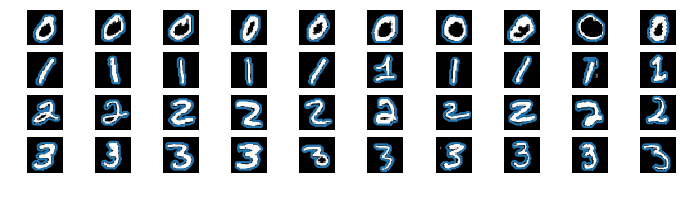

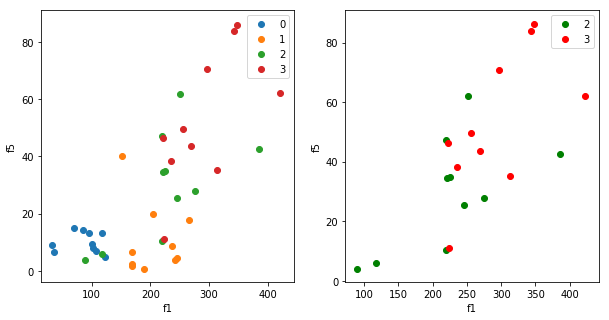

In [8]:
feature_list_0=[]
feature_list_1=[]
feature_list_2=[]
feature_list_3=[]
# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_0.append([np.abs(fourier[1]),np.abs(fourier[5])])   
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_1.append([np.abs(fourier[1]),np.abs(fourier[5])])   
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_2.append([np.abs(fourier[1]),np.abs(fourier[5])])   
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_3.append([np.abs(fourier[1]),np.abs(fourier[5])])   
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    
    
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
#first plot without phase
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
feature_list_2,feature_list_3=np.array(feature_list_2),np.array(feature_list_3)
ax1.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
ax1.scatter(feature_list_2.T[0], feature_list_2.T[1],label='2')
ax1.scatter(feature_list_3.T[0], feature_list_3.T[1],label='3')
ax1.set_xlabel('f1')
ax1.set_ylabel('f5')
ax1.legend()

ax2.scatter(feature_list_2.T[0], feature_list_2.T[1],label='2',c='g')
ax2.scatter(feature_list_3.T[0], feature_list_3.T[1],label='3',c='r')
ax2.set_xlabel('f1')
ax2.set_ylabel('f5')
ax2.legend()
plt.show()

### 2.3 Region based descriptors

Since the Fourier descriptors are not efficient enough to perform the task, the region based descriptors could do the work. However, using the same method as before, these features doesn't perform better.

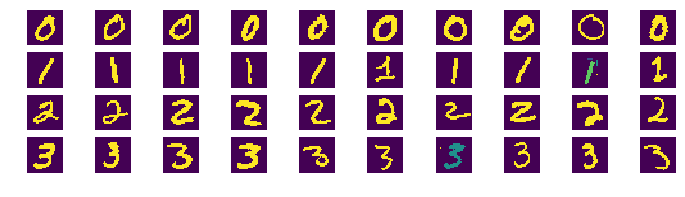

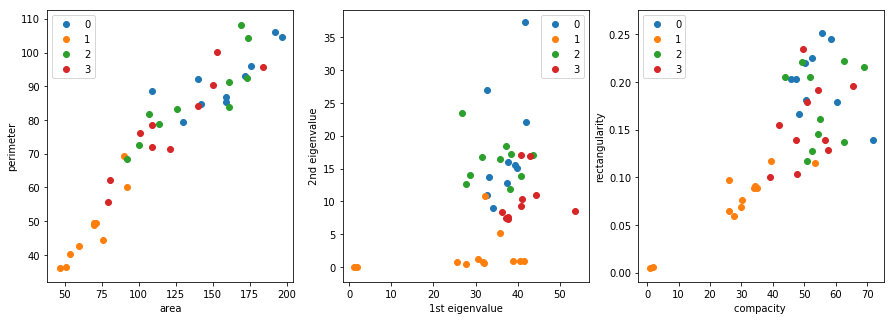

In [9]:
from skimage import measure
from skimage.morphology import binary_opening,erosion,closing,square
from skimage.morphology import skeletonize
from matplotlib.lines import Line2D 

feature_list_0,feature_list_0_ev,feature_list_0_cr=[],[],[]
feature_list_1,feature_list_1_ev,feature_list_1_cr=[],[],[]
feature_list_2,feature_list_2_ev,feature_list_2_cr=[],[],[]
feature_list_3,feature_list_3_ev,feature_list_3_cr=[],[],[]
# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    feature_list_0.append([0,0])   
    for props in regions:
        #adding area and perimeter as feature
        feature_list_0[-1][0]=max(feature_list_0[-1][0],props.area)
        feature_list_0[-1][1]=max(feature_list_0[-1][1],props.perimeter)       
        #selecting the largest area (for 1_8)
        if props.area == max(feature_list_0[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_0_ev.append([eigvals[0],eigvals[1]])           
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_0_cr.append([compacity ,rectangularity])
            
    ax.imshow(label_img)
    ax.axis('off')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    feature_list_1.append([0,0])   
    for props in regions:
        #adding area and perimeter as feature
        feature_list_1[-1][0]=max(feature_list_1[-1][0],props.area)
        feature_list_1[-1][1]=max(feature_list_1[-1][1],props.perimeter)       
        #selecting the largest area (for 1_8)
        if props.area == max(feature_list_1[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_1_ev.append([eigvals[0],eigvals[1]])           
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_1_cr.append([compacity ,rectangularity])
            
    ax.imshow(label_img)
    ax.axis('off')
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    feature_list_2.append([0,0])   
    for props in regions:
        #adding area and perimeter as feature
        feature_list_2[-1][0]=max(feature_list_2[-1][0],props.area)
        feature_list_2[-1][1]=max(feature_list_2[-1][1],props.perimeter)       
        #selecting the largest area (for 1_8)
        if props.area == max(feature_list_2[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_2_ev.append([eigvals[0],eigvals[1]])           
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_2_cr.append([compacity ,rectangularity])
            
    ax.imshow(label_img)
    ax.axis('off')
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    feature_list_3.append([0,0])   
    for props in regions:
        #adding area and perimeter as feature
        feature_list_3[-1][0]=max(feature_list_3[-1][0],props.area)
        feature_list_3[-1][1]=max(feature_list_3[-1][1],props.perimeter)       
        #selecting the largest area (for 1_8)
        if props.area == max(feature_list_3[-1][0],props.area):
            #eigenvalues
            eigvals=props.inertia_tensor_eigvals
            feature_list_3_ev.append([eigvals[0],eigvals[1]])           
            #compacity and rectangularity
            compacity = (props.perimeter**2)/props.area
            rectangularity = props.area/props.bbox_area
            feature_list_3_cr.append([compacity ,rectangularity])
            
    ax.imshow(label_img)
    ax.axis('off')
    
    
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15, 5))
feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
feature_list_2,feature_list_3=np.array(feature_list_2),np.array(feature_list_3)
ax1.scatter(feature_list_0.T[0], feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1.T[0], feature_list_1.T[1],label='1')
ax1.scatter(feature_list_2.T[0], feature_list_2.T[1],label='2')
ax1.scatter(feature_list_3.T[0], feature_list_3.T[1],label='3')
ax1.set_xlabel('area')
ax1.set_ylabel('perimeter')
ax1.legend()

feature_list_0_ev,feature_list_1_ev=np.array(feature_list_0_ev),np.array(feature_list_1_ev)
feature_list_2_ev,feature_list_3_ev=np.array(feature_list_2_ev),np.array(feature_list_3_ev)
ax2.scatter(feature_list_0_ev.T[0], feature_list_0_ev.T[1],label='0')
ax2.scatter(feature_list_1_ev.T[0], feature_list_1_ev.T[1],label='1')
ax2.scatter(feature_list_2_ev.T[0], feature_list_2_ev.T[1],label='2')
ax2.scatter(feature_list_3_ev.T[0], feature_list_3_ev.T[1],label='3')
ax2.set_xlabel('1st eigenvalue')
ax2.set_ylabel('2nd eigenvalue')
ax2.legend()

feature_list_0_cr,feature_list_1_cr=np.array(feature_list_0_cr),np.array(feature_list_1_cr)
feature_list_2_cr,feature_list_3_cr=np.array(feature_list_2_cr),np.array(feature_list_3_cr)
ax3.scatter(feature_list_0_cr.T[0], feature_list_0_cr.T[1],label='0')
ax3.scatter(feature_list_1_cr.T[0], feature_list_1_cr.T[1],label='1')
ax3.scatter(feature_list_2_cr.T[0], feature_list_2_cr.T[1],label='2')
ax3.scatter(feature_list_3_cr.T[0], feature_list_3_cr.T[1],label='3')
ax3.set_xlabel('compacity ')
ax3.set_ylabel('rectangularity')
ax3.legend()


plt.show()

### 2.4 hybrid descriptors
Adding a third dimension and thus a third feature allows a better discrimination. In order to take the best of each method, 3 differents set of features are proposed. The first one use only fourier descriptors (0, 1 and 5), the second one take the area as the third dimension and the last one use the second eigenvalue as the third descriptors.

Using the 3d visualization, it seems the fouriers descriptors method is the best. Using eigenvalues allows a better discrimination of 3 and 2, but the two and ones are still mixed sometimes due to other features.

To allow the 3d visualization, the cell needs sometimes to be executed twice. If not avaible due to the computer the notebook is executed on, the 3d plots can be displayed using "%matplotlib inline" instead of "%matplotlib qt5"

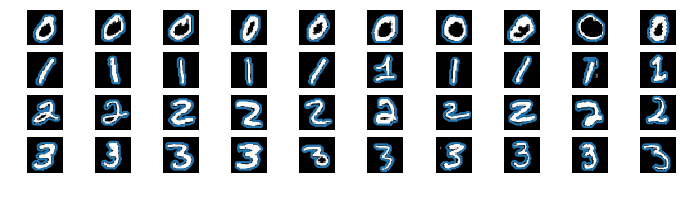

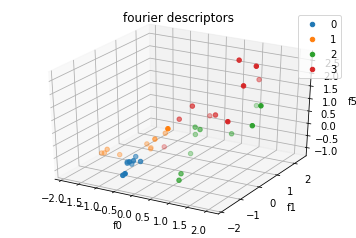

----- fourier descriptors variances -----
intra-class variance for zeros  : 0.11, 0.02 and 0.03
intra-class variance for ones   : 0.17, 0.25 and 0.37
intra-class variance for twos   : 0.70, 0.59 and 0.37
intra-class variance for threes : 0.44, 0.90 and 0.37



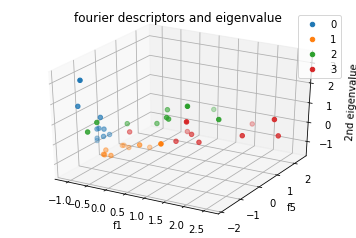

----- fourier descriptors and eigenvalue variances -----
intra-class variance for zeros  : 0.11, 0.02 and 1.06
intra-class variance for ones   : 0.17, 0.25 and 0.16
intra-class variance for twos   : 0.70, 0.59 and 0.16
intra-class variance for threes : 0.44, 0.90 and 0.20



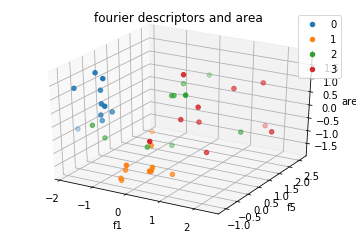

----- fourier descriptors and area variances -----
intra-class variance for zeros  : 0.11, 0.02 and 0.38
intra-class variance for ones   : 0.17, 0.25 and 0.12
intra-class variance for twos   : 0.70, 0.59 and 0.53
intra-class variance for threes : 0.44, 0.90 and 0.56



In [10]:
from mpl_toolkits.mplot3d import Axes3D
feature_list_0,feature_list_0_ev,feature_list_0_fr,feature_list_0_ar=[],[],[],[]
feature_list_1,feature_list_1_ev,feature_list_1_fr,feature_list_1_ar=[],[],[],[]
feature_list_2,feature_list_2_ev,feature_list_2_fr,feature_list_2_ar=[],[],[],[]
feature_list_3,feature_list_3_ev,feature_list_3_fr,feature_list_3_ar=[],[],[],[]
%matplotlib inline
##Uncoment following line to display interactive 3d vizualization
#%matplotlib qt5
# Plot images
fig, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    props_feature=regions[np.argmax([props.area for props in regions])]
    eigvals=props_feature.inertia_tensor_eigvals
    feature_list_0_ev.append(eigvals[1])
    feature_list_0_ar.append(props_feature.area)
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_0.append([np.abs(fourier[1]),np.abs(fourier[5])])
    feature_list_0_fr.append(np.abs(fourier[0]))
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)    
    props_feature=regions[np.argmax([props.area for props in regions])]
    eigvals=props_feature.inertia_tensor_eigvals
    feature_list_1_ev.append(eigvals[1])
    feature_list_1_ar.append(props_feature.area)
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_1.append([np.abs(fourier[1]),np.abs(fourier[5])])
    feature_list_1_fr.append(np.abs(fourier[0]))
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[2], twos_im, twos_names):
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    props_feature=regions[np.argmax([props.area for props in regions])]
    eigvals=props_feature.inertia_tensor_eigvals
    feature_list_2_ev.append(eigvals[1])
    feature_list_2_ar.append(props_feature.area)
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_2.append([np.abs(fourier[1]),np.abs(fourier[5])])
    feature_list_2_fr.append(np.abs(fourier[0]))
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
for ax, im, nm in zip(axes[3], threes_im, threes_names):
    
    #regions detections
    label_img = measure.label(im>100) #converting to binary 
    #label_img= erosion(label_img,square(2))
    regions = measure.regionprops(label_img)
    props_feature=regions[np.argmax([props.area for props in regions])]
    eigvals=props_feature.inertia_tensor_eigvals
    feature_list_3_ev.append(eigvals[1])
    feature_list_3_ar.append(props_feature.area)
    #contours definition using marching squares
    contours = measure.find_contours(im, 0.8)   
    #signal creation
    signal = contours[0][:, 0]+(1j*contours[0][:, 1])   
    #fourier transform
    fourier=fft(signal)   
    #2 first coef extraction
    feature_list_3.append([np.abs(fourier[1]),np.abs(fourier[5])])
    feature_list_3_fr.append(np.abs(fourier[0]))
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')


feature_list_0,feature_list_1=np.array(feature_list_0),np.array(feature_list_1)
feature_list_2,feature_list_3=np.array(feature_list_2),np.array(feature_list_3)
#normalization

f1=np.concatenate((feature_list_0.T[0],feature_list_1.T[0],feature_list_2.T[0],feature_list_3.T[0]))
f2=np.concatenate((feature_list_0.T[1],feature_list_1.T[1],feature_list_2.T[1],feature_list_3.T[1]))
f3=np.concatenate((feature_list_0_fr,feature_list_1_fr,feature_list_2_fr,feature_list_3_fr))
feature_list_0.T[0]=(feature_list_0.T[0]-np.mean(f1))/(np.std(f1))
feature_list_1.T[0]=(feature_list_1.T[0]-np.mean(f1))/(np.std(f1))
feature_list_2.T[0]=(feature_list_2.T[0]-np.mean(f1))/(np.std(f1))
feature_list_3.T[0]=(feature_list_3.T[0]-np.mean(f1))/(np.std(f1))

feature_list_0.T[1]=(feature_list_0.T[1]-np.mean(f2))/(np.std(f2))
feature_list_1.T[1]=(feature_list_1.T[1]-np.mean(f2))/(np.std(f2))
feature_list_2.T[1]=(feature_list_2.T[1]-np.mean(f2))/(np.std(f2))
feature_list_3.T[1]=(feature_list_3.T[1]-np.mean(f2))/(np.std(f2))

feature_list_0_fr=(feature_list_0_fr-np.mean(f3))/(np.std(f3))
feature_list_1_fr=(feature_list_1_fr-np.mean(f3))/(np.std(f3))
feature_list_2_fr=(feature_list_2_fr-np.mean(f3))/(np.std(f3))
feature_list_3_fr=(feature_list_3_fr-np.mean(f3))/(np.std(f3))

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(feature_list_0_fr, feature_list_0.T[0],feature_list_0.T[1],label='0')
ax1.scatter(feature_list_1_fr, feature_list_1.T[0],feature_list_1.T[1],label='1')
ax1.scatter(feature_list_2_fr, feature_list_2.T[0],feature_list_2.T[1],label='2')
ax1.scatter(feature_list_3_fr, feature_list_3.T[0],feature_list_3.T[1],label='3')
ax1.set_xlabel('f0')
ax1.set_ylabel('f1')
ax1.set_zlabel('f5')
ax1.set_title('fourier descriptors')
ax1.legend()
plt.show()
print("----- fourier descriptors variances -----")
print('intra-class variance for zeros  : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1]),np.var(feature_list_0_fr)))
print('intra-class variance for ones   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1]),np.var(feature_list_1_fr)))
print('intra-class variance for twos   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_2.T[0]),np.var(feature_list_2.T[1]),np.var(feature_list_2_fr)))
print('intra-class variance for threes : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_3.T[0]),np.var(feature_list_3.T[1]),np.var(feature_list_3_fr)))
print("")

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
f3=np.concatenate((feature_list_0_ev,feature_list_1_ev,feature_list_2_ev,feature_list_3_ev))
feature_list_0_ev=(feature_list_0_ev-np.mean(f3))/(np.std(f3))
feature_list_1_ev=(feature_list_1_ev-np.mean(f3))/(np.std(f3))
feature_list_2_ev=(feature_list_2_ev-np.mean(f3))/(np.std(f3))
feature_list_3_ev=(feature_list_3_ev-np.mean(f3))/(np.std(f3))
ax2.scatter(feature_list_0.T[1], feature_list_0.T[0],feature_list_0_ev,label='0')
ax2.scatter(feature_list_1.T[1], feature_list_1.T[0],feature_list_1_ev,label='1')
ax2.scatter(feature_list_2.T[1], feature_list_2.T[0],feature_list_2_ev,label='2')
ax2.scatter(feature_list_3.T[1], feature_list_3.T[0],feature_list_3_ev,label='3')
ax2.set_xlabel('f1')
ax2.set_ylabel('f5')
ax2.set_zlabel('2nd eigenvalue')
ax2.set_title('fourier descriptors and eigenvalue')
ax2.legend()
plt.show()
print("----- fourier descriptors and eigenvalue variances -----")
print('intra-class variance for zeros  : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1]),np.var(feature_list_0_ev)))
print('intra-class variance for ones   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1]),np.var(feature_list_1_ev)))
print('intra-class variance for twos   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_2.T[0]),np.var(feature_list_2.T[1]),np.var(feature_list_2_ev)))
print('intra-class variance for threes : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_3.T[0]),np.var(feature_list_3.T[1]),np.var(feature_list_3_ev)))
print("")

fig = plt.figure()
ax3 = fig.add_subplot(111, projection='3d')
f3=np.concatenate((feature_list_0_ar,feature_list_1_ar,feature_list_2_ar,feature_list_3_ar))
feature_list_0_ar=(feature_list_0_ar-np.mean(f3))/(np.std(f3))
feature_list_1_ar=(feature_list_1_ar-np.mean(f3))/(np.std(f3))
feature_list_2_ar=(feature_list_2_ar-np.mean(f3))/(np.std(f3))
feature_list_3_ar=(feature_list_3_ar-np.mean(f3))/(np.std(f3))
ax3.scatter(feature_list_0.T[0], feature_list_0.T[1],feature_list_0_ar,label='0')
ax3.scatter(feature_list_1.T[0], feature_list_1.T[1],feature_list_1_ar,label='1')
ax3.scatter(feature_list_2.T[0], feature_list_2.T[1],feature_list_2_ar,label='2')
ax3.scatter(feature_list_3.T[0], feature_list_3.T[1],feature_list_3_ar,label='3')
ax3.set_xlabel('f1')
ax3.set_ylabel('f5')
ax3.set_zlabel('area')
ax3.set_title('fourier descriptors and area')
ax3.legend()
plt.show()
print("----- fourier descriptors and area variances -----")
print('intra-class variance for zeros  : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_0.T[0]),np.var(feature_list_0.T[1]),np.var(feature_list_0_ar)))
print('intra-class variance for ones   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_1.T[0]),np.var(feature_list_1.T[1]),np.var(feature_list_1_ar)))
print('intra-class variance for twos   : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_2.T[0]),np.var(feature_list_2.T[1]),np.var(feature_list_2_ar)))
print('intra-class variance for threes : {:.02f}, {:.02f} and {:.02f}'.format(np.var(feature_list_3.T[0]),np.var(feature_list_3.T[1]),np.var(feature_list_3_ar)))
print("")

